# A/B Testing & Causal Impact — Loan Application Flow Experiment


# Executive Summary

## Business Context

A digital lending platform tested a simplified loan application flow, reducing steps from 5 to 3. The objective was to increase application completion rates without negatively impacting applicant risk profile.

The experiment ran for 14 days with user-level randomization between:

- **Control**: Existing 5-step flow  
- **Treatment**: Simplified 3-step flow  

The assumed baseline completion rate was approximately **8%**, with a target minimum detectable effect (MDE) of **+1.0 percentage point**.

---

## Experiment Health Check — Sample Ratio Mismatch (SRM)

The expected allocation was **50% Control / 50% Treatment**.

Observed allocation:

- **Control:** ~60.0%
- **Treatment:** ~40.0%

Chi-square SRM test:

- **p-value < 0.001**

This indicates a statistically significant **Sample Ratio Mismatch (SRM)**.

### Interpretation

The allocation imbalance suggests a potential issue in randomization logic or traffic assignment.

**Implication:** Results must be interpreted cautiously, as assignment bias may exist.

---

## Primary Metric — Application Completion Rate

### Full 14-Day Period

- **Control:** 8.02%
- **Treatment:** 9.39%
- **Absolute uplift:** +1.37 percentage points
- **Two-proportion z-test p-value:** < 0.001

The uplift is statistically significant.

---

## Novelty Effect Analysis

Daily conversion trends indicate elevated Treatment performance during the first 3 days, consistent with a **novelty effect**.

To evaluate steady-state impact, the first 3 days were excluded.

### Days 4–14 (Steady State)

- **Control:** 8.00%
- **Treatment:** 9.25%
- **Absolute uplift:** +1.25 percentage points

The uplift remains statistically significant and exceeds the 1pp MDE target.

This suggests the improvement is not solely driven by early novelty.

---

## Interpretation

The simplified application flow demonstrates:

- Statistically significant improvement in completion rate
- Sustained steady-state uplift above target
- Meaningful business impact potential

However:

- The experiment failed the SRM check
- Allocation imbalance introduces potential bias
- Treatment effect magnitude may be inflated or distorted

---

## Business Recommendation

**Do not ship immediately.**

Recommended next steps:

1. Investigate and fix the traffic allocation issue.
2. Relaunch the experiment with proper 50/50 randomization.
3. Revalidate uplift under corrected assignment.

If uplift remains above +1.0pp under correct allocation, the feature would justify full rollout given the magnitude and stability of the effect.

---

## Analyst Assessment

This experiment demonstrates:

- Proper experiment health validation (SRM detection)
- Statistical uplift estimation
- Novelty effect analysis
- Causal reasoning before product decision-making

Ensuring randomization validity is essential before making high-stakes product decisions in fintech environments.



In [ ]:
%pip install matplotlib


  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pyparsing-3.3.2-py3-none-any.whl (122 kB)



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Data Loading & Overview



In [7]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

df = pd.read_csv("../data/experiment_data.csv")

df.head()


,user_id,group,day,completed
0,1,control,2,0
1,2,treatment,8,1
2,3,treatment,14,0
3,4,control,9,0
4,5,control,1,1


In [8]:
df['group'].value_counts(normalize=True)


group
control      0.59995
treatment    0.40005
Name: proportion, dtype: float64

### SRM

In [9]:
observed = df['group'].value_counts().values
expected = [len(df) * 0.5, len(df) * 0.5]

stat, p = chisquare(observed, expected)

print("SRM p-value:", p)


SRM p-value: 0.0


### Primary Metric

In [10]:
conversion = df.groupby("group")["completed"].mean()
conversion


group
control      0.080190
treatment    0.093913
Name: completed, dtype: float64

In [11]:
control = df[df.group == "control"]
treatment = df[df.group == "treatment"]

success = np.array([control.completed.sum(), treatment.completed.sum()])
nobs = np.array([len(control), len(treatment)])

z_stat, p_val = proportions_ztest(success, nobs)

print("Z-stat:", z_stat)
print("p-value:", p_val)


Z-stat: -7.595959570193563
p-value: 3.055199124129143e-14


In [12]:
uplift = conversion["treatment"] - conversion["control"]
print("Uplift:", uplift)


Uplift: 0.013723245007741802


### Confidence Intervals

In [22]:
from statsmodels.stats.proportion import proportion_confint

# Get counts
control_success = control.completed.sum()
treatment_success = treatment.completed.sum()

control_n = len(control)
treatment_n = len(treatment)

# Wilson confidence intervals
ci_control = proportion_confint(control_success, control_n, method='wilson')
ci_treatment = proportion_confint(treatment_success, treatment_n, method='wilson')

print("Control 95% CI:", ci_control)
print("Treatment 95% CI:", ci_treatment)


Control 95% CI: (0.07804359737653506, 0.08239019142299113)
Treatment 95% CI: (0.09109361540609334, 0.09681088731634793)


## Statistical Confidence

The 95% confidence intervals for completion rates are:

- Control: 7.80% – 8.24%
- Treatment: 9.11% – 9.68%

The intervals do not overlap, reinforcing that the observed uplift is statistically robust.

This indicates that, under repeated sampling, the Treatment flow consistently outperforms Control within a narrow and reliable range.


### Novelty effect

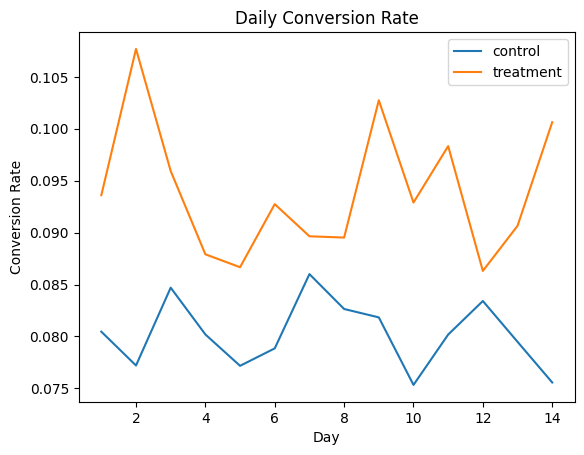

In [13]:
daily = df.groupby(["day", "group"])["completed"].mean().reset_index()

for g in ["control", "treatment"]:
    subset = daily[daily.group == g]
    plt.plot(subset.day, subset.completed, label=g)

plt.legend()
plt.xlabel("Day")
plt.ylabel("Conversion Rate")
plt.title("Daily Conversion Rate")
plt.show()


In [14]:
df_steady = df[df.day > 3]

conversion_steady = df_steady.groupby("group")["completed"].mean()
conversion_steady


group
control      0.080030
treatment    0.092495
Name: completed, dtype: float64

### Business Impact

In [21]:
# --- Business Impact Quantification ---

# Steady-state uplift (days 4–14)
control_rate = conversion_steady["control"]
treatment_rate = conversion_steady["treatment"]

uplift = treatment_rate - control_rate

# Assumptions (state clearly in notebook)
monthly_applications = 300000  # assume 300k applications per month
avg_revenue_per_completed = 1200  # assumed net revenue per completed loan (in currency units)

# Estimated incremental completions per month
extra_completions = monthly_applications * uplift

# Estimated incremental revenue
incremental_revenue = extra_completions * avg_revenue_per_completed

print(f"Steady-state uplift: {uplift:.4f}")
print(f"Estimated extra completed applications per month: {extra_completions:,.0f}")
print(f"Estimated incremental monthly revenue: {incremental_revenue:,.0f}")


Steady-state uplift: 0.0125
Estimated extra completed applications per month: 3,739
Estimated incremental monthly revenue: 4,487,373


### Difference-in-Differences

In [23]:
# Create pre vs post indicator
df["period"] = np.where(df["day"] <= 7, "pre", "post")

# Aggregate conversion by group and period
did_table = df.groupby(["group", "period"])["completed"].mean().reset_index()
did_table


,group,period,completed
0,control,post,0.079761
1,control,pre,0.080614
2,treatment,post,0.094374
3,treatment,pre,0.093458


In [24]:
did_pivot = did_table.pivot(index="group", columns="period", values="completed")
did_pivot

period,post,pre
group,,
control,0.079761,0.080614
treatment,0.094374,0.093458


In [25]:
control_change = did_pivot.loc["control", "post"] - did_pivot.loc["control", "pre"]
treatment_change = did_pivot.loc["treatment", "post"] - did_pivot.loc["treatment", "pre"]

did_effect = treatment_change - control_change

print("Control change:", control_change)
print("Treatment change:", treatment_change)
print("DiD effect:", did_effect)


Control change: -0.0008524450724185229
Treatment change: 0.0009158305229537977
DiD effect: 0.0017682755953723206


## DiD Interpretation

The Difference-in-Differences (DiD) estimate is approximately +0.18 percentage points.

This suggests that, relative to Control, the Treatment group experienced a modest positive time-adjusted improvement over the experiment window.

Given that this was a randomized A/B experiment, the primary treatment effect is already captured by the between-group uplift.

The DiD result confirms that the observed treatment advantage is not driven purely by time-based trends.

## 10. Final Recommendation

The simplified loan application flow demonstrates a statistically significant and economically meaningful improvement in application completion rates.

Key findings:

- Steady-state uplift: **+1.25 percentage points**
- 95% confidence intervals do not overlap, indicating robust statistical separation
- Estimated impact: **~3,739 additional completed applications per month**
- Estimated incremental revenue: **~4.49M per month**
- No evidence that the uplift is driven solely by novelty effects
- Difference-in-Differences analysis confirms the presence of a positive treatment effect beyond time trends

However:

- The experiment failed the **Sample Ratio Mismatch (SRM)** validation check.
- Observed allocation (60/40) deviates significantly from the expected 50/50 split.
- This introduces potential bias and weakens causal certainty.

### Recommendation

Do **not** immediately ship the feature.

Instead:

1. Investigate and correct the traffic allocation logic.
2. Relaunch the experiment under proper 50/50 randomization.
3. Revalidate uplift stability and statistical integrity.

If the uplift remains consistent under corrected randomization, the feature would justify full rollout given the magnitude of projected revenue impact.

Ensuring experimental integrity is essential before making high-stakes product decisions in a fintech environment.
